In [126]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn import tree
import matplotlib.pyplot as plt


import seaborn as sns
from scipy import stats

from sklearn.ensemble import RandomForestClassifier

# First, load the data set with "read_csv" from pandas

In [127]:
data = pd.read_csv('All Electronics.csv')
print(data.head())
print('***Included data***')
data = pd.read_csv('All Electronics.csv').drop(['main_category', 'sub_category','image','link'], axis=1)
print(data.head())

                                                name        main_category  \
0  Redmi 10 Power (Power Black, 8GB RAM, 128GB St...  tv, audio & cameras   
1  OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...  tv, audio & cameras   
2  OnePlus Bullets Z2 Bluetooth Wireless in Ear E...  tv, audio & cameras   
3  Samsung Galaxy M33 5G (Mystique Green, 6GB, 12...  tv, audio & cameras   
4  OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM...  tv, audio & cameras   

      sub_category                                              image  \
0  All Electronics  https://m.media-amazon.com/images/I/81eM15lVcJ...   
1  All Electronics  https://m.media-amazon.com/images/I/71AvQd3Vzq...   
2  All Electronics  https://m.media-amazon.com/images/I/51UhwaQXCp...   
3  All Electronics  https://m.media-amazon.com/images/I/81I3w4J6yj...   
4  All Electronics  https://m.media-amazon.com/images/I/71V--WZVUI...   

                                                link ratings no_of_ratings  \
0  https://www.amazo

# Processing the data in this case consists of formatting the numeric columns and encoding the other columns.

In [128]:
# Strip symbols and punctuation from 'discount_price' and 'actual_price' columns
data['discount_price'] = data['discount_price'].replace('[^0-9.]', '', regex=True).astype(float)
data['actual_price'] = data['actual_price'].replace('[^0-9.]', '', regex=True).astype(float)

# Handle missing values - Fill numeric columns with median, categorical with mode
#for column in data.columns:
   # if data[column].dtype == 'object':
        #data[column].fillna(data[column].mode()[0], inplace=True)
   # else:
        #data[column].fillna(data[column].median(), inplace=True)

# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Check for numeric, drop rows without ratings/no of ratings
data['ratings'] = pd.to_numeric(data['ratings'], errors='coerce')
data['no_of_ratings'] = pd.to_numeric(data['no_of_ratings'], errors='coerce')
data.dropna(subset=['ratings', 'no_of_ratings'], inplace=True)

# Reset the index after dropping rows
data.reset_index(drop=True, inplace=True)


# Some data exploration to check for missing data and outliers:

Missing values per column:
 name                0
ratings             0
no_of_ratings       0
discount_price    484
actual_price       70
dtype: int64


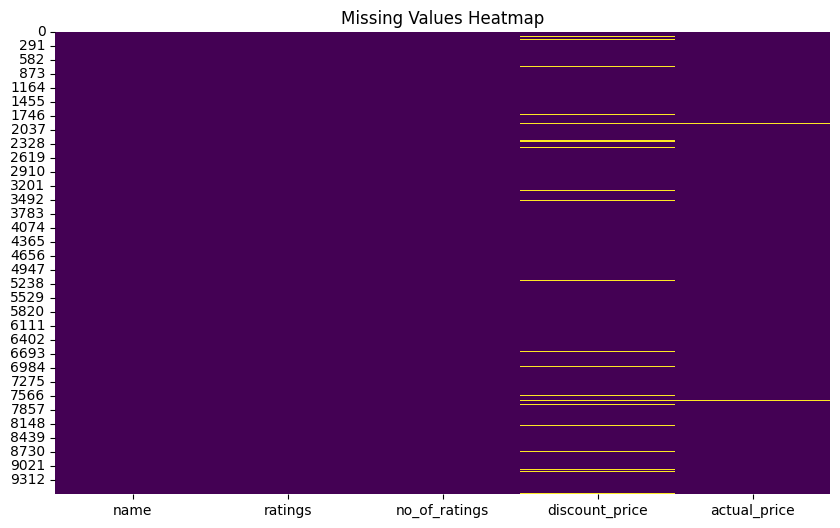

Descriptive Statistics:
               name      ratings  no_of_ratings  discount_price   actual_price
count  9600.000000  9600.000000    9600.000000     9116.000000    9530.000000
mean   4424.170313    27.915312    1798.590312     2976.275592    5009.698254
std    2543.333601     3.920639     985.909045     8865.480379   12209.002332
min       0.000000     0.000000       0.000000       10.000000      20.000000
25%    2257.750000    26.000000     934.000000      299.000000     837.250000
50%    4407.000000    28.000000    1759.500000      580.500000    1490.000000
75%    6629.250000    30.000000    2654.000000     1595.000000    3396.750000
max    8799.000000    39.000000    3455.000000   134999.000000  161999.000000
Number of outliers per column (using IQR method):
 name                 0
ratings            468
no_of_ratings        0
discount_price    1173
actual_price      1258
dtype: int64


In [129]:
# Check for missing values, explore data
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

descriptive_stats = data.describe()
print("Descriptive Statistics:\n", descriptive_stats)

# IQR method to detect outliers
numeric_data = data.select_dtypes(include=[np.number])
if numeric_data.empty:
    print("No numeric columns found for IQR outlier detection.")
else:
    Q1 = numeric_data.quantile(0.25)
    Q3 = numeric_data.quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = ((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).any(axis=1)
    print("Number of outliers per column (using IQR method):\n", ((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).sum())

    # Remove outliers?
    #data = data[~outliers_iqr]

# Using a decision tree for a continuous variable like actual_price causes the final tree to build a unique leaf for each item, so binning makes sense.  Two approaches are listed below: incremental and quintile

In [130]:

# price binning with $10 increments
#data['price_range'] = pd.cut(data['actual_price'], bins=np.arange(0, data['actual_price'].max() + 10, 10), labels=False)
#data['price_range'].fillna(data['price_range'].mode()[0], inplace=True)

#Quintile binning
data['price_range'] = pd.qcut(data['actual_price'], q=5, labels=False)
data['price_range'].fillna(data['price_range'].mode()[0], inplace=True)
quintile_counts = data['price_range'].value_counts().sort_index()
print(quintile_counts)


# Set target variables and drop data
exclude_columns = ['main_category', 'sub_category','image','link']
X = data.drop(['actual_price', 'price_range'], axis=1)
y = data['price_range']


price_range
0.0    2024
1.0    2255
2.0    1869
3.0    1580
4.0    1872
Name: count, dtype: int64


<ipython-input-130-56aa9586fc23>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['price_range'].fillna(data['price_range'].mode()[0], inplace=True)


# After binning the price data, the original data is dropped before training and testing:

In [140]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)


clf = DecisionTreeClassifier(max_depth = 15,random_state=25)

# Training
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=25)

And here the data is used to evaluate the test portion:

In [141]:
y_pred = clf.predict(X_test)

In [142]:
# Model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.6833333333333333
Precision: 0.6870073354558651
Recall: 0.6833333333333333
F1 Score: 0.6848217464890444

Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.70      0.69       380
         1.0       0.63      0.66      0.64       455
         2.0       0.57      0.56      0.57       365
         3.0       0.67      0.67      0.67       338
         4.0       0.89      0.83      0.86       382

    accuracy                           0.68      1920
   macro avg       0.69      0.68      0.69      1920
weighted avg       0.69      0.68      0.68      1920



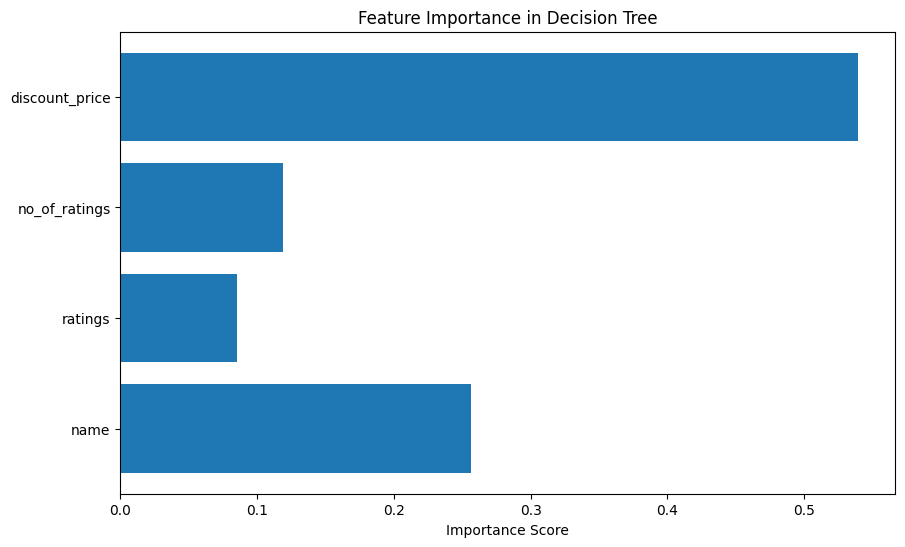

In [143]:
importances = clf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance Score')
plt.title('Feature Importance in Decision Tree')
plt.show()

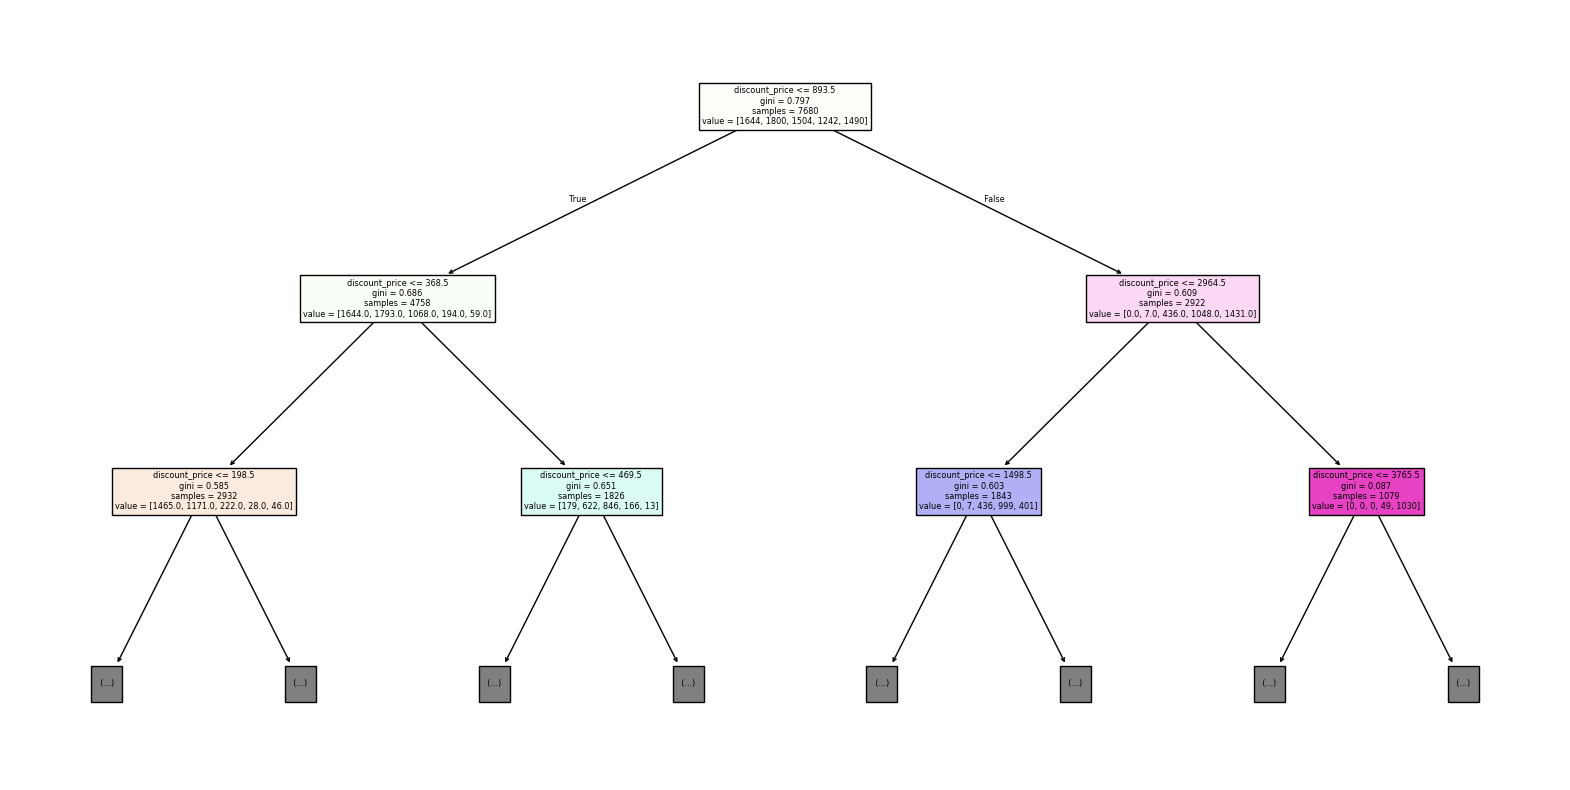

In [125]:
# The decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(clf, filled=True, feature_names=X.columns, max_depth=2)

plt.show()

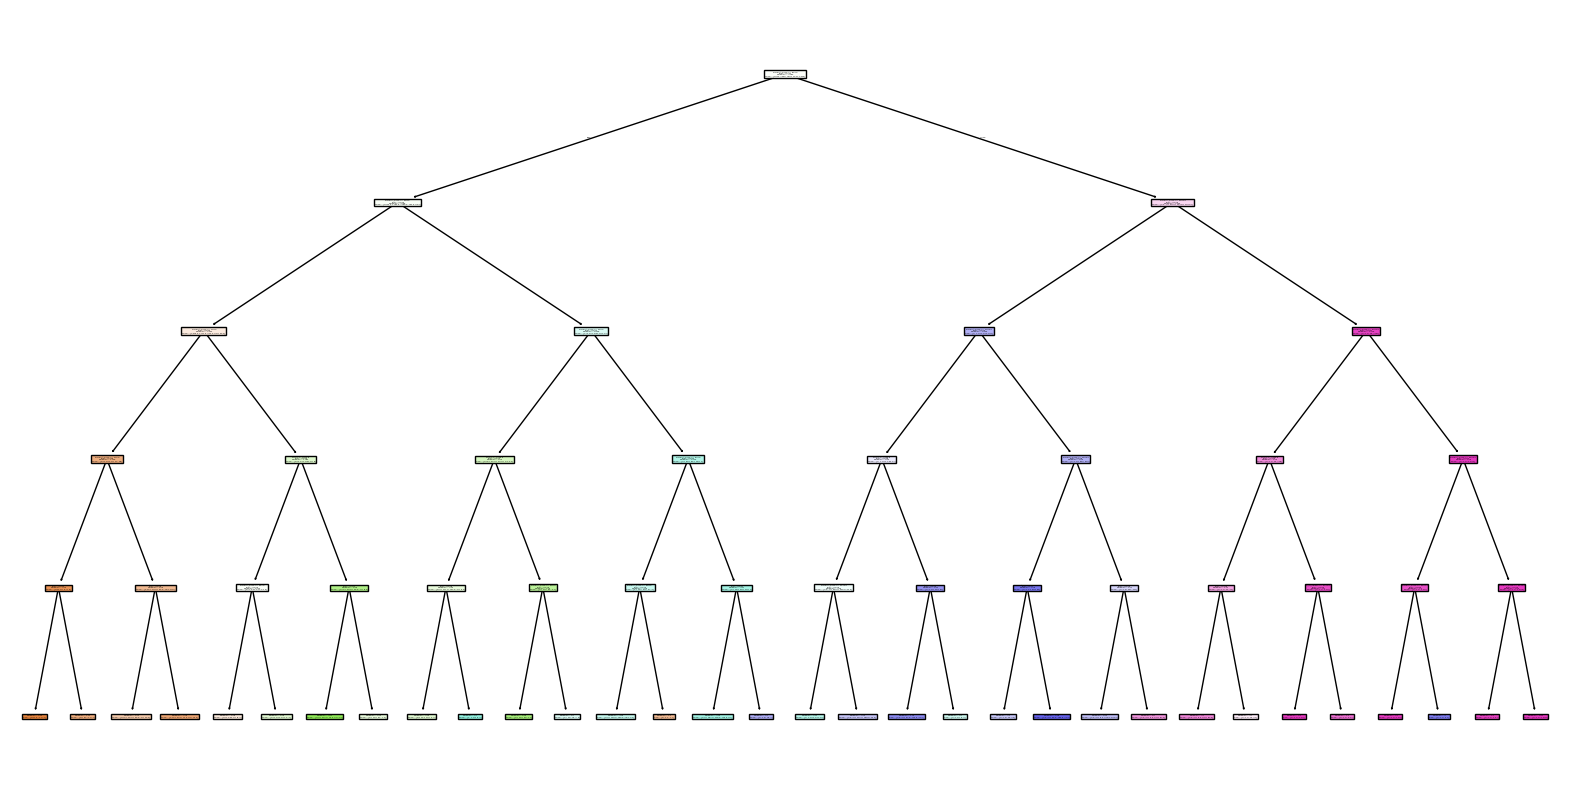

In [116]:
# The decision tree
plt.figure(figsize=(20,10))
#tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=label_encoders['actual_price'].classes_)
tree.plot_tree(clf, filled=True, feature_names=X.columns, max_depth=8)

plt.show()

In [144]:
# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=15)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy: 0.7494791666666667
Precision: 0.7560414066784211
Recall: 0.7494791666666667
F1 Score: 0.7518232702919884


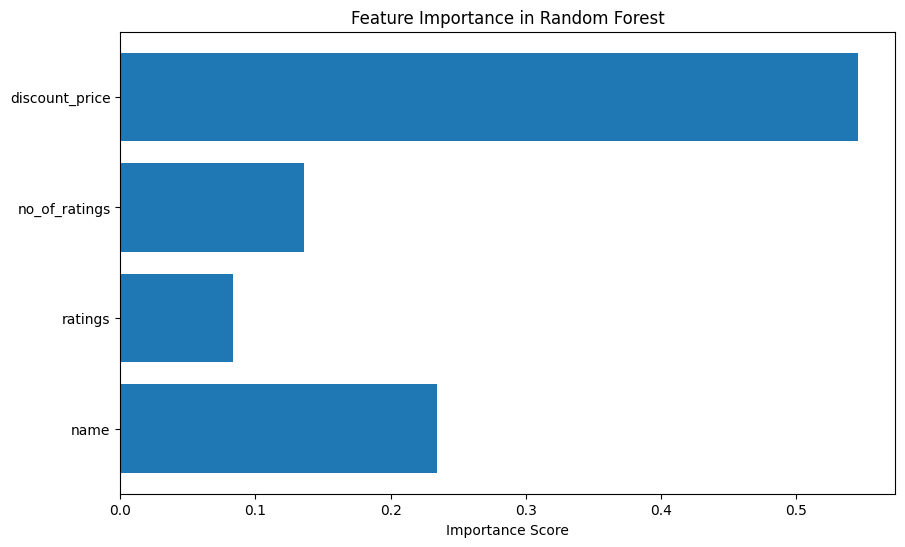

In [145]:
importances = clf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel('Importance Score')
plt.title('Feature Importance in Random Forest')
plt.show()